## Problem 1
HIV is a virus that targets CD4+T cells. These cells are responsible for fighting infections, so HIV leads to decreased auto-immune performance. The loss in T cells causes AIDS. AIDS is not an infection, but the condition of not having enough T cells.

## Problem 2
There are treatments to reduce the virus and boosting the immune system by increasing the T cells. Since there are side effects, you have to balance the negative side effects of the drugs and the benefits of the treatment.

## Problem 3-5

In [1]:
# Dependencies for this lab's code:
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt

#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i-th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in xrange(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [2]:
a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 1000

In [3]:
# initialize global variables, state, costate, and u.
state = np.zeros((n,2))
state0 = np.array([T0, V0])
costate = np.zeros((n,2))
costate0 = np.zeros(2)
u = np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9

# define state equations
def state_equations(t,y,i):
    """
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    Returns
    --------------
    y_dot : ndarray (2,)
        the derivative of the T cell concentration and the virus
        concentration at time t
    """
    T_,V_ = y[0], y[1]
    
    dT = s_1 - s_2*V_/(B_1 + V_) - mu*T_ - k*V_*T_ + u[i,0]*T_
    dV = g*V_/(B_2 + V_)*(1 - u[i,1]) - c*V_*T_
    
    return np.array([dT,dV])

def lambda_hat(t,y,i):
    """
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    """
    
    # index backwords
    j = (n-1) - i
    
    lam1, lam2 = y[0], y[1]
    T, V = state[:,0], state[:,1]
    u1_, u2_ = u[:,0], u[:,1]
    
    dlam1 = lam1*(-mu-k*V[j] + u1_[j]) - c*lam2*V[j] -1
    
    dlam2 = -lam1*(s_2*B_1/((B_1 + V[j])**2) + k*T[j]) + \
            lam2*(g*B_2*(1 - u2_[j])/((B_2 + V[j])**2) - c*T[j])
    
    return np.array([dlam1,dlam2])

In [4]:
epsilon = 0.001
test = epsilon + 1
while(test > epsilon):
    oldu = u.copy()
    
    #solve the state equations with forward iteration
    state = RK4(state_equations, state0, 0, t_f, n)
    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat, costate0, 0, t_f, n)[::-1]
    
    #solve for u1 and u2
    u1_term = -1/(2*A_1)*costate[:,0]*state[:,0]
    u2_term = costate[:,1]*g*state[:,1]/(2*A_2*(B_2 + state[:,1]))
    
    u1_max1 = np.maximum(a_1*np.ones(n), u1_term)
    u2_max2 = np.maximum(a_2*np.ones(n), u2_term)
    
    u1 = np.minimum( u1_max1, b_1*np.ones(n) )
    u2 = np.minimum( u2_max2, b_2*np.ones(n) )
    
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #test for convergence
    test = abs(oldu - u).sum()

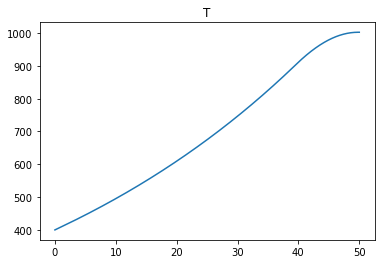

In [5]:
import matplotlib.pyplot as plt
time = np.linspace(0,t_f,n)

plt.plot(time, u[:,0])
plt.title("u1")
plt.show()

plt.plot(time, u[:,1])
plt.title("u2")
plt.show()

plt.plot(time, state[:,0])
plt.title("T")
plt.show()

plt.plot(time, state[:,1])
plt.title("V")
plt.show()